# Celestial Vision — Accuracy Maxing (Issue #156)
### Issue #156 – ACCURACY MAXING! Lets maximize accuracy

**Goal:** Maximize classification accuracy using advanced training strategies  
**Constraints:**  
- No online / hosted APIs  
- Fully offline & reproducible  
- Kaggle-compatible  

This notebook builds on the baseline CNN pipeline and introduces:
- Strong data augmentation
- Deeper from-scratch CNN
- Label smoothing
- AdamW + cosine scheduler
- AMP (mixed precision)
- Class-wise evaluation & confusion matrix


In [117]:
import os
import time
import random
import numpy as np
from PIL import Image
from pathlib import Path

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder

from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns


In [118]:
import torch

torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

print("TF32 enabled:", torch.backends.cuda.matmul.allow_tf32)


TF32 enabled: True


In [119]:
SEED = 42

def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

seed_everything(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [120]:
def safe_pil_loader(path):
    try:
        with open(path, "rb") as f:
            img = Image.open(f)
            return img.convert("RGB")
    except Exception:
        return None

class SafeImageFolder(ImageFolder):
    def __getitem__(self, index):
        path, target = self.samples[index]
        img = safe_pil_loader(path)
        if img is None:
            return self.__getitem__((index + 1) % len(self.samples))
        if self.transform:
            img = self.transform(img)
        return img, target


## Data Augmentation Strategy

Astronomical images vary in:
- Orientation
- Brightness
- Scale

We apply **strong augmentation** to improve generalization while keeping
evaluation deterministic.


In [121]:
train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(
        brightness=0.2,
        contrast=0.2,
        saturation=0.2,
        hue=0.05
    ),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

eval_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


In [122]:
class DatasetSplitter:
    def __init__(self, source_dir, output_dir, split_ratio=(0.7, 0.2, 0.1), seed=42):
        self.source_dir = Path(source_dir)
        self.output_dir = Path(output_dir)
        self.train_ratio, self.test_ratio, self.eval_ratio = split_ratio
        self.seed = seed
        random.seed(self.seed)

    def _create_dirs(self, classes):
        for split in ["train", "test", "eval"]:
            for cls in classes:
                (self.output_dir / split / cls).mkdir(parents=True, exist_ok=True)

    def split(self):
        classes = [d.name for d in self.source_dir.iterdir() if d.is_dir()]
        self._create_dirs(classes)

        for cls in classes:
            images = list((self.source_dir / cls).glob("*"))
            random.shuffle(images)

            total = len(images)
            train_end = int(self.train_ratio * total)
            test_end = train_end + int(self.test_ratio * total)

            splits = {
                "train": images[:train_end],
                "test": images[train_end:test_end],
                "eval": images[test_end:]
            }

            for split, files in splits.items():
                for file in files:
                    target = self.output_dir / split / cls / file.name
                    if not target.exists():
                        os.symlink(file, target)


In [123]:
SOURCE_DATASET_PATH = "/kaggle/input/spacenet-an-optimally-distributed-astronomy-data/SpaceNet.FLARE.imam_alam"
OUTPUT_DATASET_PATH = "/kaggle/working/dataset"

splitter = DatasetSplitter(
    source_dir=SOURCE_DATASET_PATH,
    output_dir=OUTPUT_DATASET_PATH,
    split_ratio=(0.7, 0.2, 0.1)
)

splitter.split()

print("Dataset successfully split into train / test / eval directories.")


Dataset successfully split into train / test / eval directories.


In [124]:
DATASET_ROOT = "/kaggle/working/dataset"

train_ds = SafeImageFolder(os.path.join(DATASET_ROOT, "train"), transform=train_transforms)
val_ds   = SafeImageFolder(os.path.join(DATASET_ROOT, "eval"),  transform=eval_transforms)
test_ds  = SafeImageFolder(os.path.join(DATASET_ROOT, "test"),  transform=eval_transforms)

train_loader = DataLoader(
    train_ds, batch_size=128, shuffle=True,
    num_workers=2, pin_memory=True
)

val_loader = DataLoader(
    val_ds, batch_size=64, shuffle=False,
    num_workers=2, pin_memory=True
)

test_loader = DataLoader(
    test_ds, batch_size=64, shuffle=False,
    num_workers=2, pin_memory=True
)

NUM_CLASSES = len(train_ds.classes)
print("Classes:", train_ds.classes)


Classes: ['asteroid', 'black hole', 'comet', 'constellation', 'galaxy', 'nebula', 'planet', 'star']


In [125]:
def gpu_stats():
    if torch.cuda.is_available():
        allocated = torch.cuda.memory_allocated() / 1024**3
        reserved = torch.cuda.memory_reserved() / 1024**3
        print(f"GPU memory: {allocated:.2f} GB allocated | {reserved:.2f} GB reserved")

## CNN Architecture (From Scratch)

Design principles:
- Deeper convolutional blocks
- Batch Normalization
- Dropout for regularization
- No pretrained weights


In [126]:
class ConvBlock(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_c, out_c, 3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_c, out_c, 3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )

    def forward(self, x):
        return self.block(x)


class CelestialCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            ConvBlock(3, 32),
            ConvBlock(32, 64),
            ConvBlock(64, 128),
            ConvBlock(128, 256)
        )

        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)


In [127]:
model = CelestialCNN(NUM_CLASSES).to(device)

if torch.cuda.is_available():
    try:
        # New API (preferred)
        scaler = torch.amp.GradScaler("cuda")
    except TypeError:
        # Old API fallback
        scaler = torch.cuda.amp.GradScaler()
else:
    scaler = None


criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

optimizer = optim.AdamW(
    model.parameters(),
    lr=3e-4,
    weight_decay=1e-4
)

scheduler = optim.lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=25
)


## Training with AMP + Cosine LR

- Mixed precision for speed
- Gradient clipping for stability
- Epoch-level timing


In [128]:
from tqdm import tqdm

def train_one_epoch(model, loader):
    model.train()
    total_loss, correct, total = 0, 0, 0

    pbar = tqdm(loader, desc="Training", leave=False)

    for inputs, labels in pbar:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        if scaler:
            with torch.amp.autocast(device_type="cuda"):
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        total_loss += loss.item()
        _, preds = outputs.max(1)
        correct += preds.eq(labels).sum().item()
        total += labels.size(0)

        pbar.set_postfix(loss=f"{loss.item():.4f}")

    return total_loss / len(loader), correct / total


In [129]:
def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0

    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            preds = outputs.argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return correct / total


In [130]:
from tqdm import trange

EPOCHS = 25

for epoch in trange(1, EPOCHS + 1, desc="Epochs"):
    start = time.time()

    train_loss, train_acc = train_one_epoch(model, train_loader)
    val_acc = evaluate(model, val_loader)

    scheduler.step()

    if torch.cuda.is_available():
        torch.cuda.synchronize()

    elapsed = time.time() - start

    print(
        f"Epoch [{epoch}/{EPOCHS}] | "
        f"Loss: {train_loss:.4f} | "
        f"Train Acc: {train_acc*100:.2f}% | "
        f"Val Acc: {val_acc*100:.2f}% | "
        f"Time: {elapsed:.1f}s | "
        f"{gpu_stats()}"
    )


Epochs:   4%|▍         | 1/25 [14:44<5:53:59, 884.99s/it]             

GPU memory: 0.12 GB allocated | 7.28 GB reserved
Epoch [1/25] | Loss: 1.6626 | Train Acc: 41.41% | Val Acc: 47.40% | Time: 885.0s | None



Epochs:   8%|▊         | 2/25 [30:02<5:46:30, 903.94s/it]             

GPU memory: 0.12 GB allocated | 7.28 GB reserved
Epoch [2/25] | Loss: 1.5243 | Train Acc: 49.00% | Val Acc: 58.26% | Time: 917.2s | None



Epochs:  12%|█▏        | 3/25 [45:30<5:35:27, 914.87s/it]             

GPU memory: 0.12 GB allocated | 7.28 GB reserved
Epoch [3/25] | Loss: 1.4478 | Train Acc: 52.46% | Val Acc: 46.63% | Time: 927.9s | None



Epochs:  16%|█▌        | 4/25 [59:59<5:13:52, 896.78s/it]             

GPU memory: 0.12 GB allocated | 7.28 GB reserved
Epoch [4/25] | Loss: 1.4211 | Train Acc: 54.61% | Val Acc: 53.37% | Time: 869.0s | None



Epochs:  20%|██        | 5/25 [1:14:37<4:56:41, 890.07s/it]           

GPU memory: 0.12 GB allocated | 7.28 GB reserved
Epoch [5/25] | Loss: 1.4069 | Train Acc: 55.22% | Val Acc: 60.43% | Time: 878.2s | None



Epochs:  24%|██▍       | 6/25 [1:29:07<4:39:42, 883.31s/it]           

GPU memory: 0.12 GB allocated | 7.28 GB reserved
Epoch [6/25] | Loss: 1.3605 | Train Acc: 57.44% | Val Acc: 63.85% | Time: 870.2s | None



Epochs:  28%|██▊       | 7/25 [1:44:22<4:28:07, 893.77s/it]           

GPU memory: 0.12 GB allocated | 7.28 GB reserved
Epoch [7/25] | Loss: 1.3359 | Train Acc: 59.28% | Val Acc: 62.53% | Time: 915.3s | None



Epochs:  32%|███▏      | 8/25 [1:59:16<4:13:14, 893.77s/it]           

GPU memory: 0.12 GB allocated | 7.28 GB reserved
Epoch [8/25] | Loss: 1.3176 | Train Acc: 60.50% | Val Acc: 64.93% | Time: 893.8s | None



Epochs:  36%|███▌      | 9/25 [2:13:55<3:57:05, 889.07s/it]           

GPU memory: 0.12 GB allocated | 7.28 GB reserved
Epoch [9/25] | Loss: 1.3019 | Train Acc: 60.78% | Val Acc: 64.70% | Time: 878.7s | None



Epochs:  40%|████      | 10/25 [2:28:05<3:39:14, 876.94s/it]          

GPU memory: 0.12 GB allocated | 7.28 GB reserved
Epoch [10/25] | Loss: 1.2861 | Train Acc: 61.57% | Val Acc: 63.85% | Time: 849.8s | None



Epochs:  44%|████▍     | 11/25 [2:42:49<3:25:11, 879.37s/it]          

GPU memory: 0.12 GB allocated | 7.28 GB reserved
Epoch [11/25] | Loss: 1.2670 | Train Acc: 62.78% | Val Acc: 65.24% | Time: 884.9s | None



Epochs:  48%|████▊     | 12/25 [2:57:47<3:11:42, 884.80s/it]          

GPU memory: 0.12 GB allocated | 7.28 GB reserved
Epoch [12/25] | Loss: 1.2557 | Train Acc: 63.28% | Val Acc: 66.33% | Time: 897.2s | None



Epochs:  52%|█████▏    | 13/25 [3:12:37<2:57:17, 886.46s/it]          

GPU memory: 0.12 GB allocated | 7.28 GB reserved
Epoch [13/25] | Loss: 1.2401 | Train Acc: 63.68% | Val Acc: 64.16% | Time: 890.3s | None



Epochs:  56%|█████▌    | 14/25 [3:27:30<2:42:54, 888.59s/it]          

GPU memory: 0.12 GB allocated | 7.28 GB reserved
Epoch [14/25] | Loss: 1.2300 | Train Acc: 64.79% | Val Acc: 68.89% | Time: 893.5s | None



Epochs:  60%|██████    | 15/25 [3:42:09<2:27:35, 885.53s/it]          

GPU memory: 0.12 GB allocated | 7.28 GB reserved
Epoch [15/25] | Loss: 1.1998 | Train Acc: 65.71% | Val Acc: 66.72% | Time: 878.4s | None



Epochs:  64%|██████▍   | 16/25 [3:56:58<2:12:59, 886.65s/it]          

GPU memory: 0.12 GB allocated | 7.28 GB reserved
Epoch [16/25] | Loss: 1.1975 | Train Acc: 65.89% | Val Acc: 71.14% | Time: 889.3s | None



Epochs:  68%|██████▊   | 17/25 [4:11:43<1:58:07, 885.97s/it]          

GPU memory: 0.12 GB allocated | 7.28 GB reserved
Epoch [17/25] | Loss: 1.1886 | Train Acc: 66.86% | Val Acc: 68.11% | Time: 884.4s | None



Epochs:  72%|███████▏  | 18/25 [4:26:38<1:43:42, 888.95s/it]          

GPU memory: 0.12 GB allocated | 7.28 GB reserved
Epoch [18/25] | Loss: 1.1870 | Train Acc: 66.69% | Val Acc: 70.36% | Time: 895.9s | None



Epochs:  76%|███████▌  | 19/25 [4:41:37<1:29:10, 891.80s/it]          

GPU memory: 0.12 GB allocated | 7.28 GB reserved
Epoch [19/25] | Loss: 1.1725 | Train Acc: 67.08% | Val Acc: 68.50% | Time: 898.4s | None



Epochs:  80%|████████  | 20/25 [4:56:25<1:14:12, 890.59s/it]          

GPU memory: 0.12 GB allocated | 7.28 GB reserved
Epoch [20/25] | Loss: 1.1619 | Train Acc: 68.12% | Val Acc: 73.39% | Time: 887.8s | None



Epochs:  84%|████████▍ | 21/25 [5:11:06<59:11, 887.85s/it]            

GPU memory: 0.12 GB allocated | 7.28 GB reserved
Epoch [21/25] | Loss: 1.1555 | Train Acc: 68.29% | Val Acc: 73.70% | Time: 881.5s | None



Epochs:  88%|████████▊ | 22/25 [5:25:55<44:24, 888.27s/it]            

GPU memory: 0.12 GB allocated | 7.28 GB reserved
Epoch [22/25] | Loss: 1.1510 | Train Acc: 68.14% | Val Acc: 71.61% | Time: 889.2s | None



Epochs:  92%|█████████▏| 23/25 [5:42:12<30:29, 914.79s/it]            

GPU memory: 0.12 GB allocated | 7.28 GB reserved
Epoch [23/25] | Loss: 1.1443 | Train Acc: 68.87% | Val Acc: 73.08% | Time: 976.6s | None



Epochs:  96%|█████████▌| 24/25 [5:59:16<15:47, 947.56s/it]            

GPU memory: 0.12 GB allocated | 7.28 GB reserved
Epoch [24/25] | Loss: 1.1486 | Train Acc: 68.84% | Val Acc: 73.47% | Time: 1024.0s | None



Epochs: 100%|██████████| 25/25 [6:14:06<00:00, 897.86s/it]            

GPU memory: 0.12 GB allocated | 7.28 GB reserved
Epoch [25/25] | Loss: 1.1356 | Train Acc: 69.01% | Val Acc: 73.16% | Time: 890.0s | None


## Test Set Evaluation & Error Analysis


In [131]:
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        preds = outputs.argmax(1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

cm = confusion_matrix(all_labels, all_preds)


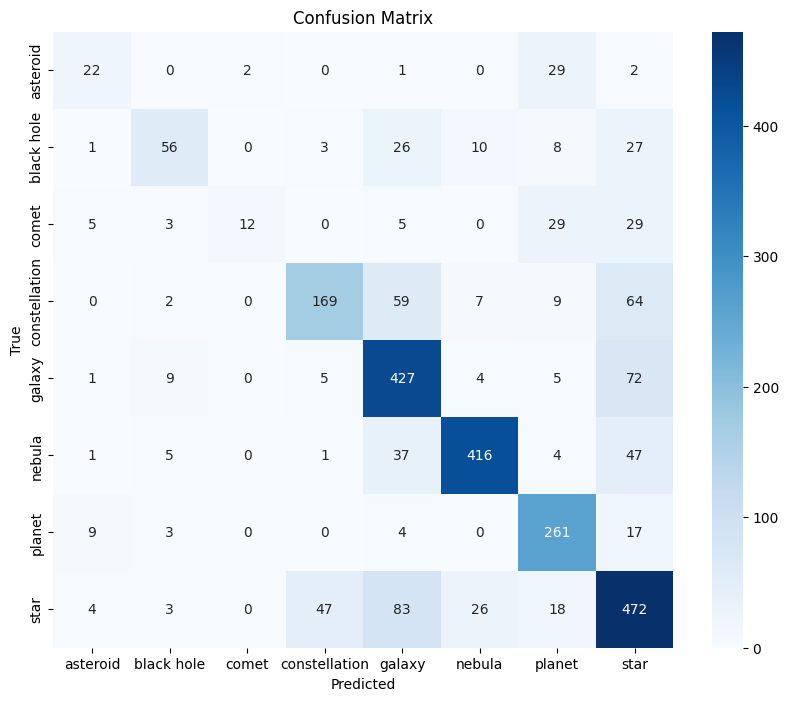

               precision    recall  f1-score   support

     asteroid       0.51      0.39      0.44        56
   black hole       0.69      0.43      0.53       131
        comet       0.86      0.14      0.25        83
constellation       0.75      0.55      0.63       310
       galaxy       0.67      0.82      0.73       523
       nebula       0.90      0.81      0.85       511
       planet       0.72      0.89      0.79       294
         star       0.65      0.72      0.68       653

     accuracy                           0.72      2561
    macro avg       0.72      0.59      0.61      2561
 weighted avg       0.73      0.72      0.71      2561



In [132]:
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=train_ds.classes,
            yticklabels=train_ds.classes,
            cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

print(classification_report(
    all_labels, all_preds,
    target_names=train_ds.classes
))
